In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import random
import h5py
from keras.datasets import cifar10
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams
from sklearn import metrics
from skimage.measure import compare_ssim
from scipy.misc import toimage
from sklearn.preprocessing import *

import os
import random
import time
from skimage import io, exposure, feature, color, transform
import matplotlib
import matplotlib.pyplot as plt
import glob

import scipy.signal as sig
import operator
import math

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

# print out floats gud
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

In [22]:
# parameters for sliding window, and window function (Hann)
STEP_SIZE = 480
OVERLAP_SIZE = 32
WINDOW_SIZE = STEP_SIZE + OVERLAP_SIZE
OVERLAP_FUNC = sig.hann(OVERLAP_SIZE * 2)

# directory that contains TIMIT files
TIMIT_DIR = "/home/sri/Desktop/timit"

# batch size
BATCH_SIZE = 64

# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# sample rate of input file (used in MFCC calculation)
SAMPLE_RATE = 16000

# number of "bins" for u-law
NBINS = 256

In [23]:
from load_TIMIT import *
from windowingFunctions import *
from utility import *

In [24]:
# read in 1000 WAVs from TIMIT training set
rawWaveforms = load_TIMIT_train(TIMIT_DIR, 100)

Reading in .wav files...


In [25]:
# waveform preprocessing
def preprocessWaveform(waveform):
    mn = np.min(waveform)
    mx = np.max(waveform)
    
    maxabs = max(abs(mn), abs(mx))
    scl = 32768.0 / maxabs    
    
    processed = waveform * scl
    
    return processed, (scl,)
    
def unpreprocessWaveform(waveform, params):
    unprocessed = waveform / params[0]
    return unprocessed



# window preprocessing
def preprocessWindows(windows):
    # scale window between -1 and 1
    processed = np.copy(windows)
    processed /= 32768.0
    
    # apply u-law transformation
    processed = np.sign(processed) * np.log(1.0 + (NBINS - 1) * np.abs(processed)) / np.log(1.0 + (NBINS - 1))
    
    # scale from 0 to 255
    processed = ((processed + 1.0) / 2.0) * (NBINS - 1)
    
    # quantize into 255 bins
    processed = np.round(processed)
    processed = processed.astype(np.int16)
    
    return processed, ()

def unpreprocessWindows(windows, params):
    # de-quantize (go from ints [0, 255] to float [-1.0, 1.0])
    unprocessed = np.copy(windows)
    unprocessed = unprocessed.astype(np.float32)
    unprocessed = (unprocessed / (NBINS - 1)) * 2.0 - 1.0
    
    # un-apply u-law transformation
    unprocessed = np.sign(unprocessed) * (np.power(NBINS, np.abs(unprocessed)) - 1) / (NBINS - 1)
    
    # scale window from [-1, 1] to [-32768, 32768]
    unprocessed *= 32768.0
    return unprocessed

In [26]:
# test data preprocessing and loss
data = np.copy(rawWaveforms[55])

processedWave, wparams = preprocessWaveform(data)
windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)
transformed, tparams = preprocessWindows(windows)

print np.max(transformed)
print np.min(transformed)

desired = unpreprocessWindows(transformed, tparams)
desired = reconstructFromWindows(desired, OVERLAP_SIZE, OVERLAP_FUNC)
desired = unpreprocessWaveform(desired, wparams)

# trim desired down to length of data
if (desired.shape[0] > data.shape[0]):
    desired = desired[:data.shape[0]]
desired = np.round(desired)
    
sciwav.write("orig.wav", 16000, data.astype(np.int16))
sciwav.write("processed.wav", 16000, desired.astype(np.int16))

print "mean l1:", np.mean(np.abs(data - desired))
print "max l1: ", np.max(np.abs(data - desired))
print "means:", np.mean(data), np.mean(desired)
print "stds: ", np.std(data), np.std(desired)
print "max/min orig:  ", np.max(data), np.min(data)
print "max/min recons:", np.max(desired), np.min(desired)

255
7
mean l1: 1.56021363606
max l1:  38.0
means: 0.471988200854 0.466357
stds:  210.915280373 210.674
max/min orig:   1379.0 -1023.0
max/min recons: 1379.0 -1016.0


In [27]:
# waveform preprocessing
processedWaveforms = np.copy(rawWaveforms)

# we maximize the volume of every waveform
for i in xrange(0, len(processedWaveforms)):
    processedWaveforms[i], _ = preprocessWaveform(processedWaveforms[i])

In [28]:
# extract windows
rawWindows = extractWindowsMultiple(processedWaveforms, STEP_SIZE, OVERLAP_SIZE,
                                    collapse = True)

# randomly shuffle data
if (RANDOM_SHUFFLE):
    rawWindows = np.random.permutation(rawWindows)

print "Raw windows shape: ", rawWindows.shape
print "Max: ", np.amax(rawWindows)
print "Min: ", np.amin(rawWindows)

Raw windows shape:  (10116, 512)
Max:  32768.0
Min:  -32768.0


In [29]:
###### data augmentation goes here, at some point
augWindows = np.copy(rawWindows)

print "Aug windows shape: ", augWindows.shape

Aug windows shape:  (10116, 512)


In [30]:
processedWindows, pwParams = preprocessWindows(augWindows)

# reshape into (WINDOW_SIZE x 1) vector form for training
X_train = np.reshape(processedWindows, (processedWindows.shape[0], WINDOW_SIZE, 1))
ntrain = X_train.shape[0]

print processedWindows.shape

print np.mean(processedWindows, axis=None)
print np.std(processedWindows, axis=None)
print np.min(processedWindows, axis = None)
print np.max(processedWindows, axis = None)

(10116, 512)
124.970972655
50.8355320904
0
255


In [31]:
# empirically estimate prior probabilities
prior_probs = np.zeros(NBINS)

for w in processedWindows:
    for i in w:
        prior_probs[i] += 1

prior_probs /= sum(prior_probs)

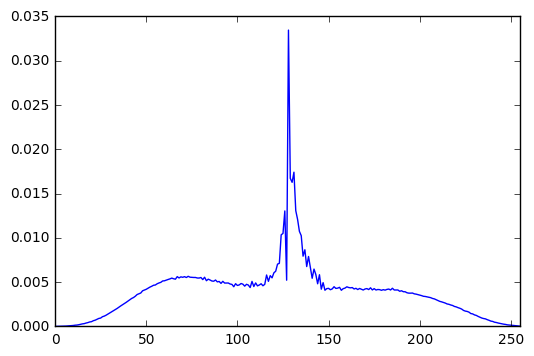

In [32]:
# plot probability distribution
from matplotlib import pyplot as plt

X = np.linspace(0, NBINS - 1, NBINS, endpoint=True)
plt.xlim(0.0, NBINS - 1)
plt.plot(prior_probs)
plt.show()

1.0


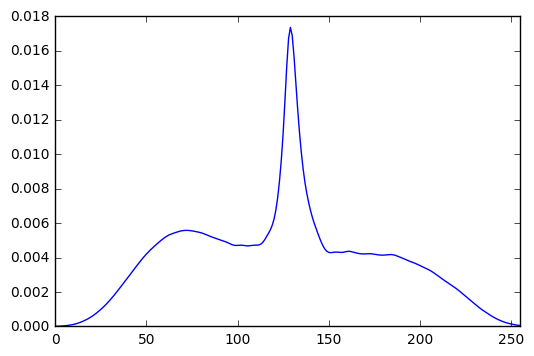

In [33]:
from scipy.ndimage.filters import gaussian_filter1d

smoothed_probs = gaussian_filter1d(prior_probs, sigma = 2.0)
print sum(smoothed_probs)
smoothed_probs /= sum(smoothed_probs)

X = np.linspace(0, NBINS - 1, NBINS, endpoint=True)
plt.xlim(0.0, NBINS - 1)
plt.plot(smoothed_probs)
plt.show()

In [34]:
# define uniform probability distribution
uni_probs = np.ones_like(smoothed_probs)
#uni_probs[prior_probs != 0] = 1
uni_probs = uni_probs / np.sum(uni_probs)

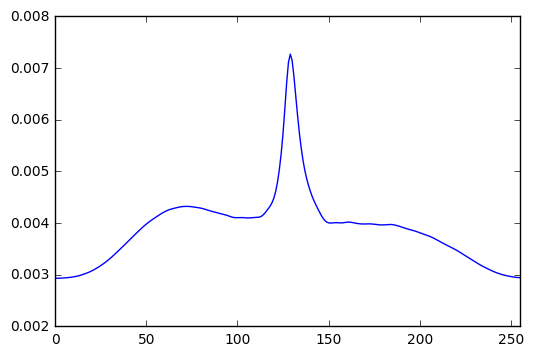

In [35]:
# convex combination of empirical prior and uniform distribution
gamma = 0.75
prior_mix = (1 - gamma) * smoothed_probs + gamma * uni_probs

# plot mix
X = np.linspace(0, NBINS - 1, NBINS, endpoint=True)
plt.xlim(0.0, NBINS - 1)
plt.plot(prior_mix)
plt.show()

In [36]:
# generate prior factors through reciprocal, normalizing s.t. E(p) = 1
prior_factors = np.array(prior_mix ** -1)
prior_factors /= np.sum(prior_mix * prior_factors)

print prior_factors

[1.332289 1.332066 1.331644 1.331037 1.330238 1.329223 1.327983 1.326508
 1.324771 1.322713 1.320269 1.317391 1.314043 1.310210 1.305912 1.301190
 1.296066 1.290528 1.284553 1.278099 1.271118 1.263596 1.255602 1.247252
 1.238627 1.229727 1.220505 1.210917 1.200944 1.190613 1.180002 1.169194
 1.158233 1.147144 1.135989 1.124880 1.113925 1.103157 1.092526 1.081982
 1.071549 1.061308 1.051316 1.041568 1.032047 1.022769 1.013754 1.005026
 0.996669 0.988803 0.981468 0.974603 0.968137 0.962049 0.956297 0.950774
 0.945374 0.940083 0.934999 0.930261 0.925957 0.922113 0.918765 0.915979
 0.913734 0.911817 0.909958 0.908090 0.906384 0.905035 0.904104 0.903548
 0.903332 0.903471 0.903979 0.904790 0.905778 0.906843 0.907964 0.909204
 0.910674 0.912474 0.914623 0.917025 0.919508 0.921891 0.924061 0.926047
 0.928023 0.930133 0.932305 0.934359 0.936265 0.938229 0.940519 0.943256
 0.946248 0.948968 0.950809 0.951501 0.951297 0.950807 0.950645 0.951098
 0.951967 0.952719 0.952867 0.952310 0.951433 0.950

In [37]:
# operations for binarization layer (THEANO ONLY)
class Binarize(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self):
        super(Binarize, self).__init__()
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        # TODO: learn threshold per parameter?
        z[0] = np.copy(x)
        z[0][z[0] < 0] = -1
        z[0][z[0] >= 0] = 1
    
    def grad(self, input, output_gradients):
        # pass through gradients unchanged
        # (i don't think there's a mathematical justification for this?)
        return [output_gradients[0]]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

    
class BinarizeLayer(Layer):
    """ Binarizes input 
    <feedforward> binarizes output of tanh to -1 and 1
    <backward> returns delta unchanged
    """
    def __init__(self, **kwargs):
        super(BinarizeLayer, self).__init__(**kwargs)
        self.op = Binarize()
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        return self.op(x)

    #def get_output_shape_for(self, input_shape):
    #    return input_shape
    
    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(BinarizeLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [83]:
input_dim = (WINDOW_SIZE, 1)
input_size = np.prod(input_dim)
bottleneck_size = 320

def wregu():
    # return l2(0.001)
    return None

# freeze weights for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):
    enc = Sequential()
    dec = Sequential()
    
    # based on architecture in this paper:
    #     http://arxiv.org/pdf/1602.02644.pdf
    # adapted to a 32x32 image instead of 64x64

    # (512x1) => (256x128)   
    enc.add(Convolution1D(64, 5, W_regularizer = wregu(), border_mode = 'same',
                          activation = 'relu', input_shape = dim,
                          init = 'uniform', bias = True))
    #enc.add(PReLU())
    enc.add(MaxPooling1D(2))
    
    # (256x64) => (128x256)    
    enc.add(Convolution1D(64, 5, W_regularizer = wregu(), border_mode = 'same',
                          activation = 'relu',
                          init = 'uniform', bias = True))
    #enc.add(PReLU())
    enc.add(MaxPooling1D(2))
    
    # (128x256) => (64x512)
    enc.add(Convolution1D(64, 5, W_regularizer = wregu(), border_mode = 'same',
                          activation = 'relu',
                          init = 'uniform', bias = True))
    #enc.add(PReLU())
    enc.add(MaxPooling1D(2))
    
    # (64x512) => (32x10)
    enc.add(Convolution1D(10, 5, W_regularizer = wregu(), border_mode = 'same',
                          activation = 'tanh',
                          init = 'uniform', bias = True))
    #enc.add(PReLU())
    enc.add(MaxPooling1D(2))
    
    # binarize   
    enc.add(Reshape((bottleneck_size,)))   
    enc.add(BinarizeLayer())

    dec.add(Reshape((32, 10,), input_shape = (bottleneck_size,)))
    
    # (32x10) => (64x512)
    dec.add(UpSampling1D(2))
    dec.add(Convolution1D(64, 5, W_regularizer = wregu(), border_mode = 'same',
                          init = 'uniform', activation = 'relu',
                          bias = True))
    #dec.add(PReLU())
    
    # (64x512) => (128x256)
    dec.add(UpSampling1D(2))
    dec.add(Convolution1D(64, 5, W_regularizer = wregu(), border_mode = 'same',
                          init = 'uniform', activation = 'relu',
                          bias = True))
    #dec.add(PReLU())
    
    # (128x256) => (256x128)
    dec.add(UpSampling1D(2))
    dec.add(Convolution1D(64, 5, W_regularizer = wregu(), border_mode = 'same',
                          init = 'uniform', activation = 'relu',
                          bias = True))
    #dec.add(PReLU())
    
    # (256x128) => (512x128)
    dec.add(UpSampling1D(2))
    dec.add(Convolution1D(64, 5, W_regularizer = wregu(), border_mode = 'same',
                          init = 'uniform', activation = 'relu',
                          bias = True))
    #dec.add(PReLU())
    
    # (512x64) => (512x256) where each 256-len vector is a softmax
    dec.add(Convolution1D(NBINS, 5, W_regularizer = wregu(), border_mode = 'same',
                          init = 'uniform', activation = 'relu',
                          bias = True))
    
    dec.add(Convolution1D(NBINS, 1, W_regularizer = wregu(), border_mode = 'same',
                          init = 'uniform', activation = 'softmax',
                          bias = True))

    return enc, dec


# ---------------------------------------------------------------------------
# discriminator: tries to differentiate between original and reconstructed samples
#     takes in vectors of size WINDOW_SIZE
# ---------------------------------------------------------------------------
def discriminator_structure(dim):
    dsc = Sequential()
    
    # INPUT: 512x256 vector
    dsc.add(Reshape((dim[0], 1), input_shape = dim))
    
    dsc.add(GaussianNoise(0.1))
    
    
    # (512x1) => (256x32)
    dsc.add(Convolution1D(96, 7, border_mode='same',
                                  W_regularizer = wregu(), init = 'uniform',
                                  activation = 'relu'))
    dsc.add(MaxPooling1D(2))
    
    # (256x32) => (128x64)
    dsc.add(Convolution1D(96, 7, border_mode='same',
                                  W_regularizer = wregu(), init = 'uniform',
                                  activation = 'relu'))
    dsc.add(MaxPooling1D(2))
    
    # (128x64) => (64x64)
    dsc.add(Convolution1D(96, 7, border_mode='same',
                                  W_regularizer = wregu(), init = 'uniform',
                                  activation = 'relu'))
    dsc.add(MaxPooling1D(2))
    
    # (64x64) => (32x128)
    dsc.add(Convolution1D(96, 7, border_mode='same',
                                  W_regularizer = wregu(), init = 'uniform',
                                  activation = 'relu'))
    dsc.add(MaxPooling1D(2))

    dsc.add(Flatten())
    #dsc.add(MinibatchDiscrimination())
    dsc.add(Dense(1, activation = 'sigmoid'))
    
    return dsc


def k_to_vec(y):
    return K.cast(K.argmax(y, axis = 2), 'float32')

    
def k_to_vec_scaled(y):
    vec = k_onehot_to_vec(y)
    return vec / 255.0 * 2.0 - 1.0

k_mult = K.variable(np.arange(0, NBINS))
def k_to_vec_expected(y):
    vec = K.round(K.dot(y, k_mult))
    return vec / 255.0 * 2.0 - 1.0


def onehot_acc_strict(y_true, y_pred):
    # convert one-hot vectors to actual vectors
    pred_vec = k_onehot_to_vec(y_pred)
    true_vec = k_onehot_to_vec(y_true)
    
    equal = K.equal(pred_vec, true_vec)
    return K.mean(equal)

def onehot_acc_loose(y_true, y_pred):
    # convert one-hot vectors to actual vectors
    pred_vec = k_onehot_to_vec(y_pred)
    true_vec = k_onehot_to_vec(y_true)
    
    diff = K.abs(pred_vec - true_vec)
    almost = K.lesser_equal(diff, 2)
    return K.mean(almost)

def onehot_mae(y_true, y_pred):
    # convert one-hot vectors to actual vectors
    pred_vec = k_onehot_to_vec(y_pred)
    true_vec = k_onehot_to_vec(y_true)
    
    return K.mean(K.abs(pred_vec - true_vec))


k_prior_factors = K.variable(prior_factors)
def weighted_categorical_crossentropy(y_true, y_pred):
    true_vec = K.argmax(y_true, axis = 2)
    weights = k_prior_factors[true_vec]
        
    return K.mean(weights * K.categorical_crossentropy(y_pred, y_true), axis = 1)



# -----------------------------------------
# construct autoencoder to be used in adversarial training
# -----------------------------------------
inp = Input(shape = input_dim)
enc, dec = autoencoder_structure(input_dim)
embedding = enc(inp)
recons = dec(embedding)
autoencoder = Model(input = [inp], output = [recons])
autoencoder.compile(loss = 'categorical_crossentropy',
              optimizer = Adam())
autoencoder.summary()


# -----------------------------------------
# construct discriminator
# -----------------------------------------
ohtv_lambda = Lambda(k_to_vec_expected, input_shape = (WINDOW_SIZE, NBINS),
                                               output_shape = (WINDOW_SIZE,))

# output: activation on original image (should be 1) or reconstruction (should be 0)
dsc_input_dim = (WINDOW_SIZE, NBINS)
dsc_input = Input(shape = dsc_input_dim )
dsc_vec = ohtv_lambda(dsc_input)
dsc_struct = discriminator_structure((WINDOW_SIZE,))
dsc_label = dsc_struct(dsc_vec)

# also compute label of reconstruction, for autoencoder feedback
recons_discrim = dsc_struct(ohtv_lambda(recons))

make_trainable(autoencoder, False)
discriminator = Model(input = [dsc_input], output = [dsc_label])
discriminator.compile(loss = ['binary_crossentropy'], optimizer = Adam(),
                      metrics = ['binary_accuracy'])
discriminator.summary()




# -----------------------------------------
# construct full model
# -----------------------------------------
output_recons = Lambda(lambda x : x, name = 'recons')(recons)
output_discrim = Lambda(lambda x : x, name = 'discrim')(recons_discrim)

all_metrics = {
               'recons': [onehot_acc_strict, onehot_acc_loose, onehot_mae],
               'discrim' : ['binary_accuracy']
              }
lweights = [1.0, 1.0 / 2.0]

# compile another model (in case i want to do other stuff during training)
make_trainable(autoencoder, True)
model = Model(input = inp, output = [output_recons, output_discrim])
model.compile(loss = ['categorical_crossentropy', 'binary_crossentropy'], loss_weights = lweights,
              metrics = all_metrics, optimizer = Adam())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_21 (InputLayer)            (None, 512, 1)        0                                            
____________________________________________________________________________________________________
sequential_32 (Sequential)       (None, 320)           44682       input_21[0][0]                   
____________________________________________________________________________________________________
sequential_33 (Sequential)       (None, 512, 256)      212864      sequential_32[1][0]              
Total params: 257546
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Con

In [84]:
pf = np.arange(0, 3)
print pf

y_true = np.array([[[0, 1, 0], [1, 0, 0]], [[0, 0, 1], [0, 0, 1]]])
tv = np.argmax(y_true, axis = 2)

y_pred = [[[0, 0.5, 0.5], [0.9, 0.1, 0]], [[0.75, 0, 0.25], [0, 0.25, 0.75]]]
y_pred_clipped = np.clip(y_pred, 1e-7, 1.0 - 1e-7)

expected = K.dot(K.variable(y_pred), K.variable(pf)).eval()


print tv
print expected

[0 1 2]
[[1 0]
 [2 2]]
[[1.500000 0.100000]
 [0.500000 1.750000]]


In [85]:
import scipy

# turns quantized windows to one-hot vectors
#     (optimized function ;) 
def windows_to_one_hot(windows, soft = False, sz = 9, std = 4.0):
    one_hot = np.zeros((windows.shape[0], windows.shape[1], NBINS))
    
    if (soft):
        # soft one-hot vector
        kernel = scipy.signal.gaussian(sz, std)
        kernel /= sum(kernel)
        
        # for each window in windows
        for i in xrange(0, windows.shape[0]):
            # this is really hacky, but it's the fastest way to do this
            # special convolution
            for j in xrange(-sz/2, (sz/2)+1):
                try:
                    one_hot[i, np.arange(windows[i].shape[0]),
                            np.where(windows[i] + j < 0, NBINS+1, windows[i] + j)] = kernel[j+(sz/2)]
                except:
                    pass
    else:
        # for each window in windows
        for i in xrange(0, windows.shape[0]):
            # set indices to 1
            one_hot[i, np.arange(windows[i].shape[0]), windows[i]] = 1
    
    return one_hot

def adjust_temperature(v, T):
    new = np.exp(np.log(v) / T)
    new /= np.sum(new)
    return new

# gets expected value of a probability distribution vector
def expected_value(v):
    return np.round(np.dot(np.arange(0, v.shape[0]), v))

# turns one-hot-vectors into quantized (by taking argmax)
def one_hot_to_windows(one_hot, recons_type = 'argmax'):
    if (recons_type == 'argmax'):
        return np.array([[np.argmax(v) for v in w] for w in one_hot])
    elif (recons_type == 'expected'):
        return np.array([[expected_value(v) for v in w] for w in one_hot])
    elif (recons_type == 'temperature'):
        return np.array([[expected_value(adjust_temperature(v, 0.5)) for v in w] for w in one_hot])


kernel = scipy.signal.gaussian(5, 0.4)
kernel /= sum(kernel)
print kernel


orig = X_train[:32, 0]
rec = one_hot_to_windows(windows_to_one_hot(orig, True, 5, 0.4))
print np.mean(np.abs(orig - rec))

[0.000003 0.040388 0.919218 0.040388 0.000003]
0.0


In [86]:
def autoencoderTest(waveFilename, prefix, autoencoder, recons_type = 'argmax', verbose = True):
    [rate, data] = sciwav.read(waveFilename)
    processedWave, wparams = preprocessWaveform(data)
    windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)
    

    # first, write desired reconstruction
    transformed, tparams = preprocessWindows(windows)
    if (verbose):
        print transformed.shape
    desired = unpreprocessWindows(transformed, tparams)
    desired = reconstructFromWindows(desired, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocessWaveform(desired, wparams)
    
    # then, run NN on transformed windows
    transformed, tparams = preprocessWindows(windows)
    
    transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
    transformed = (transformed / 255.0) * 2.0 - 1.0
    autoencOutput = autoencoder.predict(transformed, batch_size = BATCH_SIZE, verbose = (1 if verbose else 0))
    if (verbose):
        print autoencOutput.shape
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE, NBINS))
    autoencOutput = one_hot_to_windows(autoencOutput, recons_type)
    
    if (verbose):
        print autoencOutput.shape
    recons = unpreprocessWindows(autoencOutput, tparams)
    recons = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocessWaveform(recons, wparams)
    
    sciwav.write(prefix + "_output.wav", rate, recons.astype(np.int16))
    
    metrics = [
        np.max(desired),
        np.min(desired),
        np.max(recons),
        np.min(recons),
        mse(recons, desired),
        avgErr(recons, desired)
    ]
    
    if (verbose):
        print "Max/min desired:", metrics[0], metrics[1]
        print "Max/min recons: ", metrics[2], metrics[3]
        print waveFilename, " mse: ", metrics[4]
        print waveFilename, " avg err: ", metrics[5]
        
    return metrics

In [87]:
NUM_BATCHES = ntrain / BATCH_SIZE
NUM_EPOCHS = 100

lead = "    "

sz = 5
stds = [0.4]
stdIdx = 0

for epoch in range(NUM_EPOCHS):
    print "Epoch " + str(epoch + 1) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    
    # track average loss across the epoch
    totalLosses_aec = []
    avgLosses_aec = []
    totalLosses_dsc = []
    avgLosses_dsc = []
    
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
        
        a_losses = ["autoencoder not training"]
        d_loss = "discriminator not training"
        
        # convert batch to one-hot vector w/ particular std
        std = stds[stdIdx]
        batch_onehot = windows_to_one_hot(batch[:, :, 0], True, sz, std)
        
        # scale batch to [-1, 1]
        batch_scaled = (batch / 255.0) * 2.0 - 1.0
        
        # train autoencoder, if discriminator accuracy is greater than 70%
        if (epoch > 0):
            make_trainable(discriminator, False)
            make_trainable(autoencoder, True)

            a_losses = model.train_on_batch(batch_scaled, [batch_onehot, np.ones(nbatch)])
            
            if (totalLosses_aec == []):
                totalLosses_aec = np.array(a_losses)
            else:
                totalLosses_aec += np.array(a_losses)
            avgLosses_aec = totalLosses_aec / (i + 1)
        
        # train discriminator on what the autoencoder now generates
        make_trainable(discriminator, True)
        make_trainable(autoencoder, False)
        generated = autoencoder.predict(batch_scaled)
       
        discrim_batch_X = np.concatenate((batch_onehot, generated))
        discrim_batch_y = np.concatenate((np.ones(nbatch), np.zeros(nbatch)))
        d_losses = discriminator.train_on_batch(discrim_batch_X, discrim_batch_y)
        d_losses = np.asarray(d_losses)
        
        if (totalLosses_dsc == []):
            totalLosses_dsc = np.array(d_losses)
        else:
            totalLosses_dsc += np.array(d_losses)
        avgLosses_dsc = totalLosses_dsc / (i + 1)
            
        
        # print statistics every 10 batches so we know stuff is still going down
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": " + str(avgLosses_dsc) \
                                    + " and " + str(avgLosses_aec)
            print printStr,
            
        i += 1
    print ""
    
    # print elapsed time
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"
    
    # EVERY 5 EPOCHS: advance the std of soft target
    if ((epoch + 1) % 5 == 0 and stdIdx < len(stds) - 1):
        stdIdx += 1   
    
    # EVERY EPOCH: evaluate on SA1.wav
    startTime = time.time()
    print lead + "Evaluating..."
    
    metrics = autoencoderTest("./SA1.WAV", "SA1_eval_argmax_", autoencoder, 'argmax', verbose = False)
    print lead + "Metrics (argmax):     ", metrics
    metrics = autoencoderTest("./SA1.WAV", "SA1_eval_expected_", autoencoder, 'expected', verbose = False)
    print lead + "Metrics (expected):   ", metrics
    metrics = autoencoderTest("./SA1.WAV", "SA1_eval_temperature_", autoencoder, 'temperature', verbose = False)
    print lead + "Metrics (temperature):", metrics

    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    print ""

Epoch 1:
    9600: [0.174316 0.934654] and [] 
    Total time for epoch: 52.539096117s
    Evaluating...
    Metrics (argmax):      [4899.0, -4062.407, 4489.2759, -3453.7656, 465172.59, 395.45789]
    Metrics (expected):    [4899.0, -4062.407, 0.42235792, -0.42235109, 154736.16, 210.32159]
    Metrics (temperature): [4899.0, -4062.407, 0.42235792, -0.42235109, 154736.34, 210.3217]
    Total time for evaluation: 1.67783594131s

Epoch 2:
    9600: [0.306856 0.879139] and [5.942945 5.017442 1.851004 0.026979 0.085387 44.505081 0.014797] 
    Total time for epoch: 105.456598997s
    Evaluating...
    Metrics (argmax):      [4899.0, -4062.407, 4.1531439, 3.0800962, 154738.77, 210.48358]
    Metrics (expected):    [4899.0, -4062.407, 0.42235792, -2.2066667, 154717.72, 210.21588]
    Metrics (temperature): [4899.0, -4062.407, 1.2951175, -4.1531367, 154720.14, 210.04532]
    Total time for evaluation: 1.67156291008s

Epoch 3:
    9600: [0.272530 0.910389] and [5.550025 4.727581 1.644883 0.0340

In [88]:
autoencoderTest("./SA1.WAV", "SA1_aac_", autoencoder)
autoencoderTest("./SX383.WAV", "SX383_aac_", autoencoder)
autoencoderTest("./fiveYears.wav", "fy_aac_", autoencoder)

(112, 512)
112/112 [==============================] - 0s     
(112, 512, 256)
(112, 512)
Max/min desired: 4899.0 -4062.41
Max/min recons:  4113.69 -3028.95
./SA1.WAV  mse:  38398.8
./SA1.WAV  avg err:  94.6593
(93, 512)
93/93 [==============================] - 0s     
(93, 512, 256)
(93, 512)
Max/min desired: 2926.39 -3057.0
Max/min recons:  2352.11 -2681.6
./SX383.WAV  mse:  29504.8
./SX383.WAV  avg err:  75.6228
(183, 512)
183/183 [==============================] - 0s     
(183, 512, 256)
(183, 512)
Max/min desired: 19495.7 -21275.0
Max/min recons:  19495.7 -14998.7
./fiveYears.wav  mse:  1.98064e+07
./fiveYears.wav  avg err:  2873.04


[19495.682, -21275.0, 19495.682, -14998.747, 19806400.0, 2873.0391]